In [32]:
import os
import math
import numpy as np

import torch
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm
from argparse import Namespace

from GeospatialFM.datasets.GFMBench.utils import get_dataset, get_metadata
from GeospatialFM.data_process import apply_normalization, modal_specific_collate_fn, get_transform
from GeospatialFM.finetune.utils import get_task_model, get_loss_fn
from GeospatialFM.finetune.args import parse_args
from GeospatialFM.models import SpatialSpectralLowRankViTConfig, SpatialSpectralMAEViT

from functools import partial
from accelerate import Accelerator
from transformers import TrainingArguments
from safetensors import safe_open

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rasterio
import pandas as pd
import json
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def pca_vis_patch(patch, n_components=3):
    # perform PCA on patch
    pca = PCA(n_components=n_components)
    B, L, D = patch.shape
    patch_ = patch.reshape(B*L, D)
    try:
        patch_ = patch_.cpu().numpy()
    except:
        pass
    pca.fit(patch_)
    patch_pca = pca.transform(patch_)

    preprocessed_patches = patch_pca.reshape(B, int(L**0.5), int(L**0.5), 3)
    return preprocessed_patches

def norm_image(image):
    image = image - image.min()
    image = image / image.max()
    return image

In [38]:
ROOT_DIR="/home/haozhesi/Dropbox/GeospatialFM"

In [39]:
args = parse_args([
    "--data_dir", ROOT_DIR + "/data/geospatial",
    "--dataset_name", "eurosat",
    "--task_type", "classification", 
    "--scale", "4",
    "--modal", "optical",
    "--return_dict",
    "--per_device_train_batch_size", "64",
    "--gradient_accumulation_steps", "4", 
    "--num_train_epochs", "20",
    "--learning_rate", "3e-4",
    "--adam_weight_decay", "0.01",
    "--warmup_steps", "0",
    "--warmup_ratio", "0.2",
    "--report_to", "wandb",
    "--save_total_limit", "5",
    "--seed", "42",
    "--mixed_precision", "bf16",
    "--dataloader_num_workers", "32",
    "--dataloader_pin_memory",
    "--output_dir", ROOT_DIR + "/results/models",
    "--logging_dir", ROOT_DIR + "/results/logs", 
    "--wandb_dir", ROOT_DIR + "/results/",
    "--run_name", "LESSVIT_b2_d4_eurosat",
    "--lr_scheduler_type", "cosine",
    "--channel_embed_dims_per_head", "2",
    "--use_perception_field_mask",
    "--use_moe",
    "--num_experts", "3"
])

In [40]:
metadata = get_metadata(args.dataset_name)
optical_mean, optical_std = metadata["s2c"]["mean"], metadata["s2c"]["std"]
radar_mean, radar_std = metadata["s1"]["mean"], metadata["s1"]["std"]
print(optical_mean, radar_mean)
print(optical_std, radar_std)
print(metadata["size"], metadata['num_classes'])

[1354.40546513, 1118.24399958, 1042.92983953, 947.62620298, 1199.47283961, 1999.79090914, 2369.22292565, 2296.82608323, 732.08340178, 12.11327804, 1819.01027855, 1118.92391149, 2594.14080798] None
[245.71762908, 333.00778264, 395.09249139, 593.75055589, 566.4170017, 861.18399006, 1086.63139075, 1117.98170791, 404.91978886, 4.77584468, 1002.58768311, 761.30323499, 1231.58581042] None
64 10


In [41]:
collate_fn = partial(modal_specific_collate_fn, modal=args.modal)

In [42]:
crop_size = metadata["size"] if args.crop_size is None else args.crop_size
train_transform, eval_transform = get_transform(args.task_type, crop_size=crop_size, scale=args.scale, 
                                                 optical_mean=optical_mean, optical_std=optical_std, radar_mean=radar_mean, radar_std=radar_std)

In [43]:
dataset = get_dataset(args, train_transform, eval_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


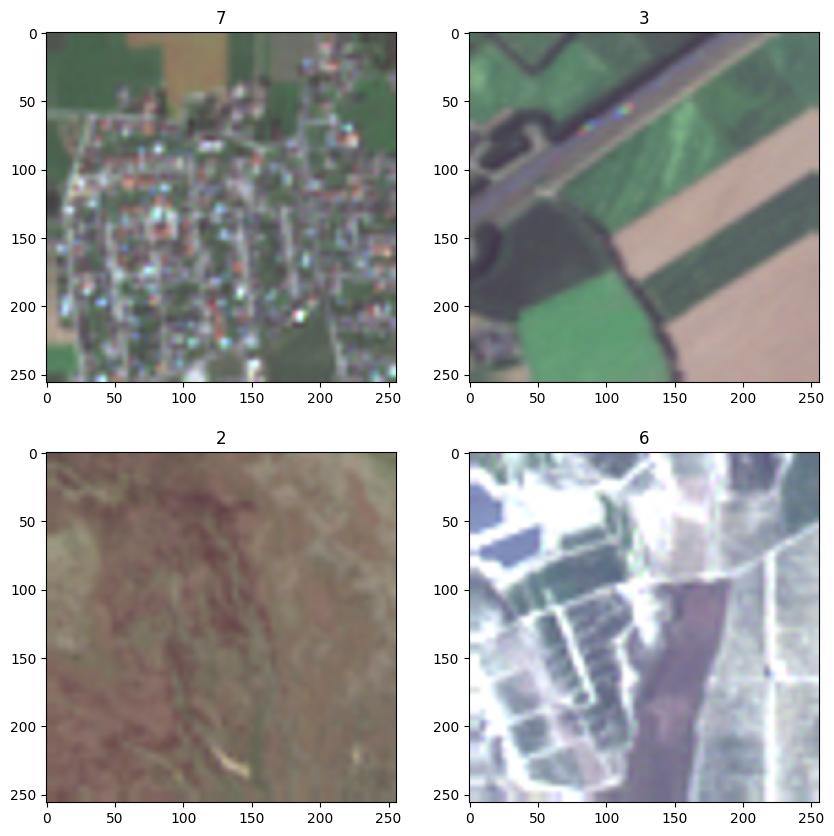

In [44]:
# visualize the dataset via matplotlib
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(dataset["train"][i]['optical'][[3, 2, 1], :, :].permute(1, 2, 0))
    plt.title(dataset["train"][i]['label'])
    # print(torch.max(dataset["train"][i]['optical']))
plt.show()

In [45]:
# len(dataset["train"][0]['optical'][0][0])
dataset['val'][1]

{'optical': tensor([[[0.1933, 0.1933, 0.1933,  ..., 0.2334, 0.2328, 0.2325],
          [0.1933, 0.1933, 0.1933,  ..., 0.2334, 0.2328, 0.2325],
          [0.1933, 0.1933, 0.1933,  ..., 0.2334, 0.2328, 0.2325],
          ...,
          [0.1830, 0.1830, 0.1830,  ..., 0.1771, 0.1771, 0.1771],
          [0.1833, 0.1833, 0.1833,  ..., 0.1771, 0.1771, 0.1771],
          [0.1834, 0.1834, 0.1834,  ..., 0.1771, 0.1771, 0.1771]],
 
         [[0.2160, 0.2160, 0.2161,  ..., 0.2594, 0.2609, 0.2616],
          [0.2160, 0.2160, 0.2161,  ..., 0.2594, 0.2609, 0.2616],
          [0.2161, 0.2161, 0.2161,  ..., 0.2594, 0.2609, 0.2616],
          ...,
          [0.2170, 0.2170, 0.2170,  ..., 0.2197, 0.2220, 0.2230],
          [0.2179, 0.2179, 0.2179,  ..., 0.2200, 0.2225, 0.2236],
          [0.2183, 0.2183, 0.2183,  ..., 0.2202, 0.2227, 0.2239]],
 
         [[0.1546, 0.1546, 0.1545,  ..., 0.2531, 0.2534, 0.2536],
          [0.1546, 0.1546, 0.1545,  ..., 0.2531, 0.2534, 0.2536],
          [0.1545, 0.1545, 0.

In [46]:
dataloader = DataLoader(dataset["val"], batch_size=4, collate_fn=collate_fn)
for i, batch in enumerate(dataloader):
    # print(batch['optical'].shape)
    for key, value in batch.items():
        print(key, value.shape)
    break
labels = batch.pop("labels")

spatial_resolution ()
labels torch.Size([4])
optical torch.Size([4, 13, 256, 256])
optical_channel_wv torch.Size([1, 13])


In [17]:
model = get_task_model(args, metadata["num_classes"], metadata["size"])
if args.pretrained_model_path:
        from safetensors import safe_open
        with safe_open(args.pretrained_model_path, framework="pt", device="cpu") as f:
            # Load only encoder weights
            for key in f.keys():
                if key.startswith("encoder."):
                    # Get the corresponding key in target model
                    param = f.get_tensor(key)
                    model.state_dict()[key].copy_(param)

In [18]:
outputs = model.encoder(**batch)

In [14]:
outputs["last_hidden_state"].shape

torch.Size([4, 14, 65, 768])

In [19]:
loss_fn = get_loss_fn(args.task_type)

In [47]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define configuration
config = SpatialSpectralLowRankViTConfig(
    patch_size=16,
    embed_dim=768,
    channel_embed_dims_per_head=1,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    decoder_channel_embed_dims_per_head=1,
    use_perception_field_mask=True,
    attention_radius=320,
    norm_pix_loss=False,
    decoder_out_chans = 15,
    pos_chan_embed_residual=True,
)

# Initialize model
model = SpatialSpectralMAEViT(config)

In [48]:
# Set model to training mode
device = 'cuda:0'
model.to(device, dtype=torch.bfloat16)
model.train()
print()

In [49]:
with safe_open("/home/haozhesi/Dropbox/GeospatialFM/results/models/LESSVIT_b1_d8/checkpoint-50000/model.safetensors", framework="pt", device=device) as f:
    state_dict = {key: f.get_tensor(key) for key in f.keys()}

# Load the state dict into the model
model.load_state_dict(state_dict)
print("Model loaded successfully from safetensors file.")

Model loaded successfully from safetensors file.


In [50]:
batch = next(iter(dataloader))
optical = batch['optical'].to(device, dtype=torch.bfloat16)
# radar = batch['radar'].to(device, dtype=torch.bfloat16)
radar = None
optical_channel_wv = batch['optical_channel_wv']
radar_channel_wv = None
spatial_resolution = batch['spatial_resolution']

In [51]:
model.eval()
with torch.no_grad():
    x, cls_token, patch_tokens, hidden_states = model.encoder(optical=optical, radar=radar, optical_channel_wv=optical_channel_wv, radar_channel_wv=radar_channel_wv, 
                                                                    spatial_resolution=spatial_resolution, mask_ratio=0, channel_mask_ratio=0.)
x, cls_token, patch_tokens = x.to(torch.float32).detach().cpu(), cls_token.to(torch.float32).detach().cpu(), patch_tokens.to(torch.float32).detach().cpu()

In [52]:
pca_patches = []
for hidden_state in hidden_states:
    hidden_state = hidden_state.to(torch.float32)
    # patches = hidden_state[:, 1:, 1:].mean(dim=1)
    patches = hidden_state[:, 0, 1:]
    # patches = hidden_state[:, 1, 1:]
    patches = pca_vis_patch(patches.numpy())
    pca_patches.append(patches)

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:685: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


In [53]:
optical.shape

torch.Size([4, 13, 256, 256])

/tmp/ipykernel_931717/1257146177.py:18: RuntimeWarning: invalid value encountered in divide
  image = image / image.max()
/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


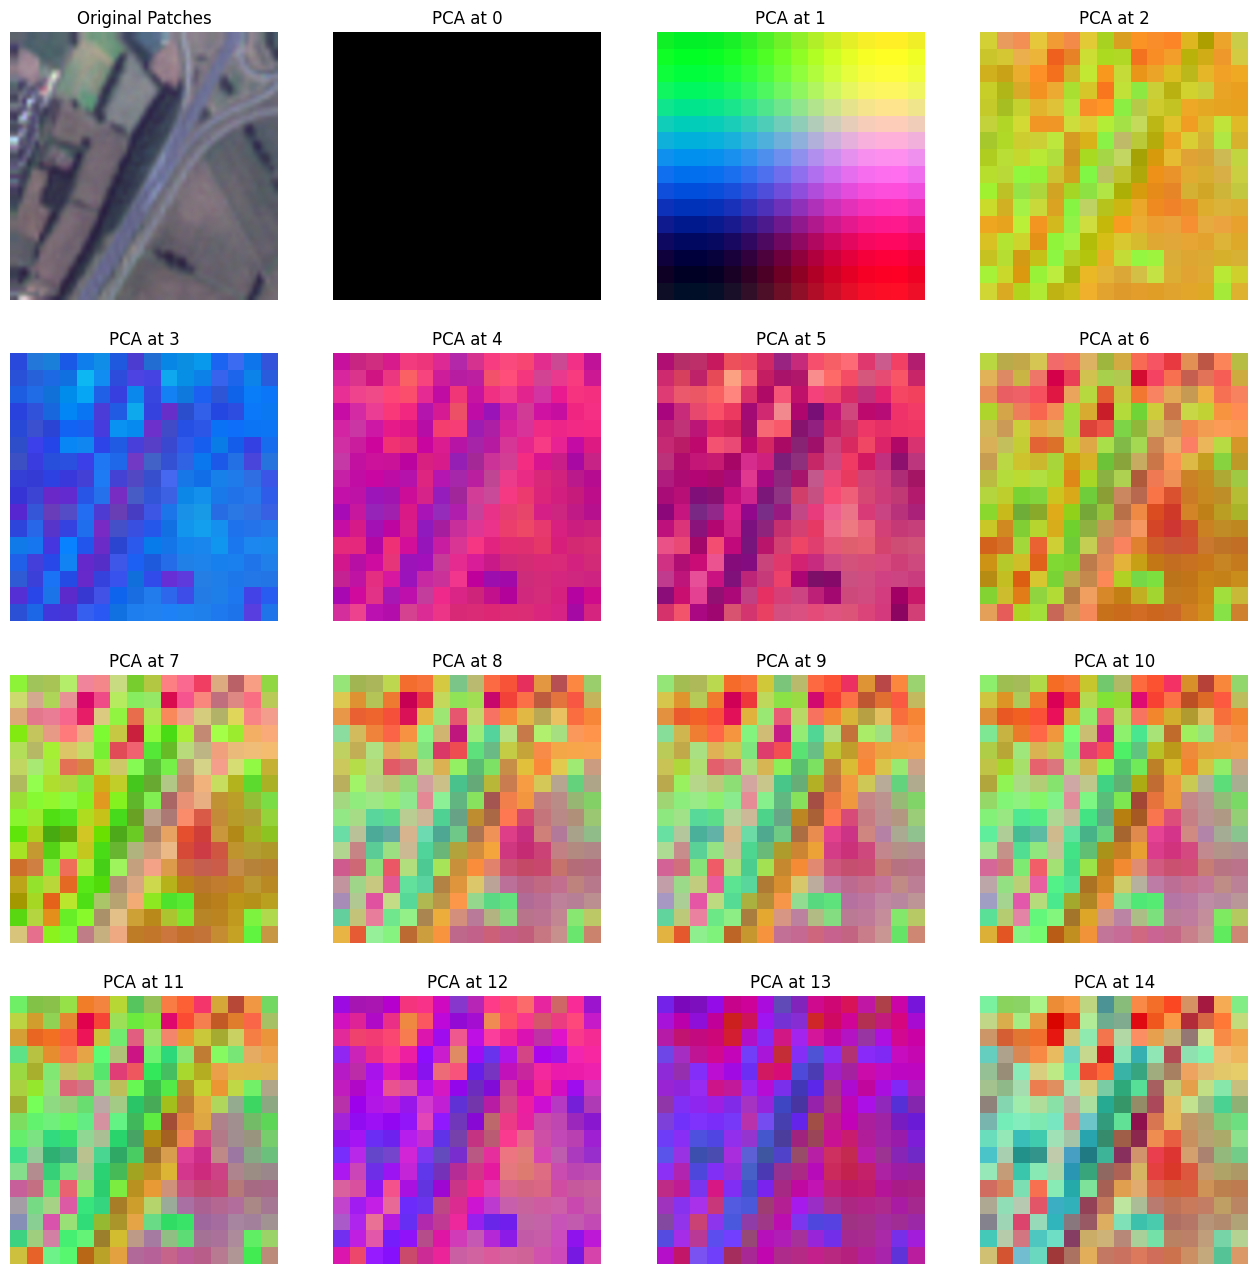

In [54]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

vis_idx = 0
for i in range(4):
    for j in range(4):
        index = i*4 + j
        if index == 0:
            axs[i, j].imshow(norm_image(optical[vis_idx].permute(1, 2, 0).to(torch.float32).detach().cpu().numpy())[..., [3,2,1]])
            axs[i, j].set_title('Original Patches')
            axs[i, j].axis('off')
        else:
            index -= 1
            axs[i, j].imshow(norm_image(pca_patches[index][vis_idx]))
            axs[i, j].set_title(f'PCA at {index}')
            axs[i, j].axis('off')
plt.show()